# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

## Downloading the dataset, importing libraries

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import random_split, DataLoader
from torchvision import transforms as T, datasets, models

## Functions definition for reproducibility and for training our models

In [36]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [4]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1,epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1,epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1,epochs+1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1,epochs+1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [58]:
def ncorrect(scores, y):
    y_hat = torch.argmax(scores, -1)
    return (y_hat == y).sum()

def accuracy(scores, y):
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False, label_smoothing=0.0, scheduler=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    train_losses, val_losses, train_accuracies, val_accuracies = [],[],[],[]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    for e in tqdm(range(1,epochs+1)):
        model.train()
        # Train
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl:
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)
            scores = model(imgs)
            loss = criterion(scores, labels)
            train_loss += loss.item() * imgs.shape[0]
            train_samples += imgs.shape[0]
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # clear
            loss.backward()  # fill
            opt.step()       # use

            learning_rate = opt.param_groups[0]['lr']

        if scheduler != False: # Implements the learning rate schedule
            scheduler.step()

        train_acc /= train_samples
        train_loss /= train_samples

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None:
                for val_data in val_dl:
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)
                    val_scores = model(imgs)
                    val_loss += criterion(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

                val_losses.append(val_loss)
                val_accuracies.append(val_acc)

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0
                best_params = model.state_dict()
                torch.save(best_params, "best_model.pth")
                best_epoch = e

        if verbose and ((e-1) % 3 == 0 or e == epochs) or scheduler != False:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}") + ( f" - lr: {learning_rate}" if scheduler != False else ""))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc:.3f}")

    plot_results(train_losses, val_losses, train_accuracies, val_accuracies, epochs)

    return best_val_acc, best_params, best_epoch

def test_model(model, best_params, dl=test_dl, str='Test'):
    model.load_state_dict(best_params)
    model.eval()

    with torch.no_grad():
        correct = 0
        total = 0
        for imgs, labels in dl:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            total += imgs.shape[0]
            correct += ncorrect(outputs, labels).item()

        print(f'{str} Accuracy: {100 * correct / total:.2f}%')

## Dataset Class definition

In [6]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Mapping label to names  
This piece of code allows the mapping between labels and class names for human readability.

In [7]:
classes_csv_path = 'GroceryStoreDataset/dataset/classes.csv'
classes_df = pd.read_csv(classes_csv_path, header=0, names=['Class_Name', 'Class_ID', 'Coarse_Class_Name', 'Coarse_Class_ID', 'Iconic_Image', 'Product_Description'])

# Extract names and labels
class_names = classes_df['Coarse_Class_Name'].tolist()
class_labels = classes_df['Coarse_Class_ID'].tolist()  # If you have a category column

# Create a mapping from label to name
label_to_name = {label: name for label, name in zip(class_labels, class_names)}
print(label_to_name)

{0: 'Apple', 1: 'Avocado', 2: 'Banana', 3: 'Kiwi', 4: 'Lemon', 5: 'Lime', 6: 'Mango', 7: 'Melon', 8: 'Nectarine', 9: 'Orange', 10: 'Papaya', 11: 'Passion-Fruit', 12: 'Peach', 13: 'Pear', 14: 'Pineapple', 15: 'Plum', 16: 'Pomegranate', 17: 'Red-Grapefruit', 18: 'Satsumas', 19: 'Juice', 20: 'Milk', 21: 'Oatghurt', 22: 'Oat-Milk', 23: 'Sour-Cream', 24: 'Sour-Milk', 25: 'Soyghurt', 26: 'Soy-Milk', 27: 'Yoghurt', 28: 'Asparagus', 29: 'Aubergine', 30: 'Cabbage', 31: 'Carrots', 32: 'Cucumber', 33: 'Garlic', 34: 'Ginger', 35: 'Leek', 36: 'Mushroom', 37: 'Onion', 38: 'Pepper', 39: 'Potato', 40: 'Red-Beet', 41: 'Tomato', 42: 'Zucchini'}


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Loading the dataset: let's study it!
Let's split the dataset into train, validation and test set and let's see how it looks like.

In [ ]:
transform = T.Compose([
    T.ToTensor()
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

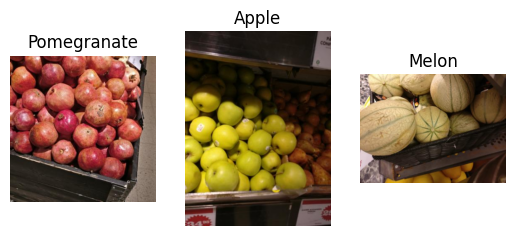

In [ ]:
_, ax = plt.subplots(1, 3)

for i, idx in enumerate([1024, 6, 524]): # plotting different images of the training set
    img, label = train_dataset[idx]
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title(label_to_name.get(label))
    ax[i].axis("off")

## Transforming the dataset!
It is clear that the dataset is made of images of different sizes. We need to apply a transformation such that all the data samples are of the same input dimensions. Moreover, since our pixel values are between 0-255 we have to apply standardization as a pre-processing step on our dataset, to work with values between 0 and 1.  
We can try to fix the input resolution to 100x100 pixels by cropping at the center, since we expect to have relevant information closer to it. We can eventually try to apply different data transformation later on, to see how it impacts the performance.

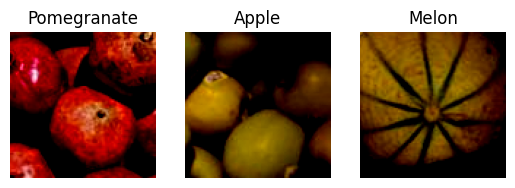

In [ ]:
transform = T.Compose([
    T.ToTensor(),
    T.CenterCrop((100,100)),
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

_, ax = plt.subplots(1, 3)

for i, idx in enumerate([1024, 6, 524]):
    img, label = train_dataset[idx]
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title(label_to_name.get(label))
    ax[i].axis("off")

We need to wrap our sets in a DataLoader structure, which will help us on training and testing our model. To do so, we also need to specify a batch size.

To avoid saturation of the GPU memory, let's set it to an intermediate value of 64.

In [12]:
batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

n_classes = train_dataset.get_num_classes()
print(f"Number of classes: {n_classes}")

Number of classes: 43


## Hyperparameter of the training
To understand and compare different versions of our model, let's fix some hyperparameters that will be used during training:  
- num_epochs = 15
- learning_rate = 0.001

15 epochs should be enough to assess the model and see its performances, with a standard value for the learning rate which can be eventually lowered through a schedule.

In [8]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 15

# Model Definition
The idea is to implement a VGG-like architecture: a stack of stages that process activations at the same spatial resolution.  
Each stage is made of:
- 3x3 convolution;
- Relu activation;
- 3x3 Maxpooling, with stride 2.  

This architecture turned out to be very simple and effective: application of small kernel with a maxpooling operator that halves the spatial dimensions and doubles the channel dimension. After the feature extractor we put a 2 fully-connected layers classifier with 1024 neurons each. Let's start from this basic model and eventually modify it in order to improve it's capacity!

In [ ]:
class Model1(nn.Module):
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # out: 49x49x64
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # out: 24x24x128
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # out: 11x11x256
    nn.Conv2d(256, 512, kernel_size=3, padding=1), # out: 11x11x512
    nn.ReLU(inplace=True)
    )
    self.classifier = nn.Sequential(
        nn.Linear(11*11*512, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

Let's use Adam as a optimizer since it is universally considered a very good optimizer on deep learning tasks.

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 3.288 - train acc 0.152 - valid loss 3.026 - valid acc 0.182
Epoch 4: train loss 1.682 - train acc 0.461 - valid loss 2.298 - valid acc 0.348
Epoch 7: train loss 0.984 - train acc 0.655 - valid loss 2.533 - valid acc 0.351
Epoch 10: train loss 0.481 - train acc 0.830 - valid loss 3.147 - valid acc 0.348
Epoch 13: train loss 0.155 - train acc 0.952 - valid loss 4.227 - valid acc 0.358
Epoch 15: train loss 0.122 - train acc 0.962 - valid loss 4.207 - valid acc 0.331
Best epoch 6, best acc 0.399


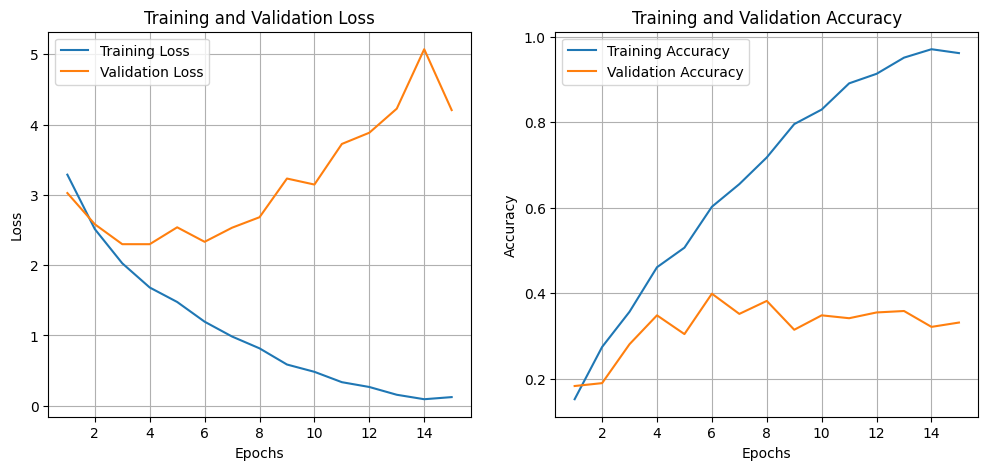

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = Model1(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc_1, best_params_1, best_epoch_1 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True)


We reached a validation accuracy of 40% which is not bad for our first try, but we can clearly see from the plots that our model is suffering from overfitting quite early during training. We must try to improve the generalization of our model, maybe by introducing some forms of regularizations. We could try by **introducing dropout regularization** and see how it works!

# Dropout regularization
Let's apply dropout with p=0.5 to our fully connected layers.

In [ ]:
class Model2(nn.Module):
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # out: 49x49x64
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # out: 24x24x128
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2), # out: 11x11x256
    nn.Conv2d(256, 512, kernel_size=3, padding=1), # out: 11x11x256
    nn.ReLU(inplace=True)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5), # <-------------
        nn.Linear(11*11*512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5), # <-------------
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 3.255 - train acc 0.155 - valid loss 3.109 - valid acc 0.189
Epoch 4: train loss 1.990 - train acc 0.361 - valid loss 2.090 - valid acc 0.348
Epoch 7: train loss 1.417 - train acc 0.529 - valid loss 1.959 - valid acc 0.355
Epoch 10: train loss 0.997 - train acc 0.667 - valid loss 1.974 - valid acc 0.378
Epoch 13: train loss 0.618 - train acc 0.794 - valid loss 2.149 - valid acc 0.412
Epoch 15: train loss 0.506 - train acc 0.822 - valid loss 2.281 - valid acc 0.453
Best epoch 15, best acc 0.453


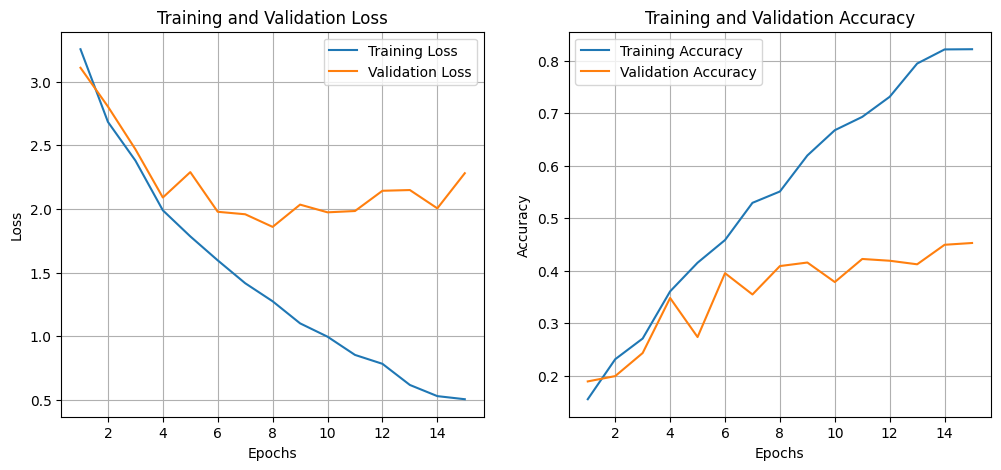

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = Model2(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc_2, best_params_2, best_epoch_2 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True
)


We have obtained an improvement on the validation accuracy of about 5%: the validation loss has a smoother trend but there is still more to improve. Since we're dealing with image classification, we could try to average out along the channel dimension at the interface between the convolutional and fully-connected layer, through **global average pooling**.  
This can be beneficial by:
- drastically reducing the number of parameters of the fully convolutional layers (of an HxW factor);
- may improve generalization since we're just interested in an high response of a feature (namely the class of the image) rather than its specific position on the image.

# Global Average Pooling
Pytorch implements an adaptive average pooling operator, which allows us to deal with input images of arbitrary resolution.

In [ ]:
class Model3(nn.Module):
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)) # out: 1x512# <-------------
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 3.441 - train acc 0.100 - valid loss 3.333 - valid acc 0.132
Epoch 4: train loss 2.372 - train acc 0.267 - valid loss 2.698 - valid acc 0.250
Epoch 7: train loss 1.932 - train acc 0.377 - valid loss 2.129 - valid acc 0.314
Epoch 10: train loss 1.644 - train acc 0.450 - valid loss 1.913 - valid acc 0.345
Epoch 13: train loss 1.400 - train acc 0.510 - valid loss 1.877 - valid acc 0.405
Epoch 15: train loss 1.296 - train acc 0.555 - valid loss 1.842 - valid acc 0.426
Best epoch 15, best acc 0.426


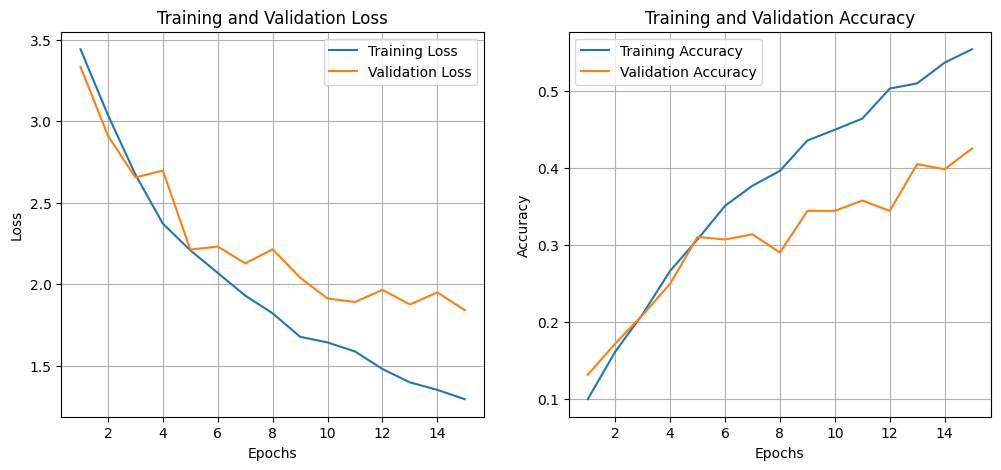

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = Model3(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc_3, best_params_3, best_epoch_3 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True
)


Even though there is no improvement on the validation accuracy, training and validation losses have a very close trend and the learning is way slower (we barely reached a 60% accuracy on the training set in 15 epochs, while it was 80% before adding average pool).  This suggest that we've improved generalization but we need more time to train the model.  
By considering this, there are 2 paths that we can follow:
- **increase the number of epochs** of training, to see if our model keeps improving as the curves seem to show;
- **increase the spatial resolution** of the input in order to extract more information that could be useful to the model to exploit relevant features.

Let's try the first one first, by also **halving the learning rate** to find a better minima. Let's train our model for **10 more epochs**, starting from the best parameter obtained so far!

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: train loss 1.186 - train acc 0.589 - valid loss 1.844 - valid acc 0.456
Epoch 4: train loss 1.010 - train acc 0.644 - valid loss 1.711 - valid acc 0.432
Epoch 7: train loss 0.908 - train acc 0.673 - valid loss 1.662 - valid acc 0.497
Epoch 10: train loss 0.907 - train acc 0.668 - valid loss 1.787 - valid acc 0.443
Best epoch 8, best acc 0.503


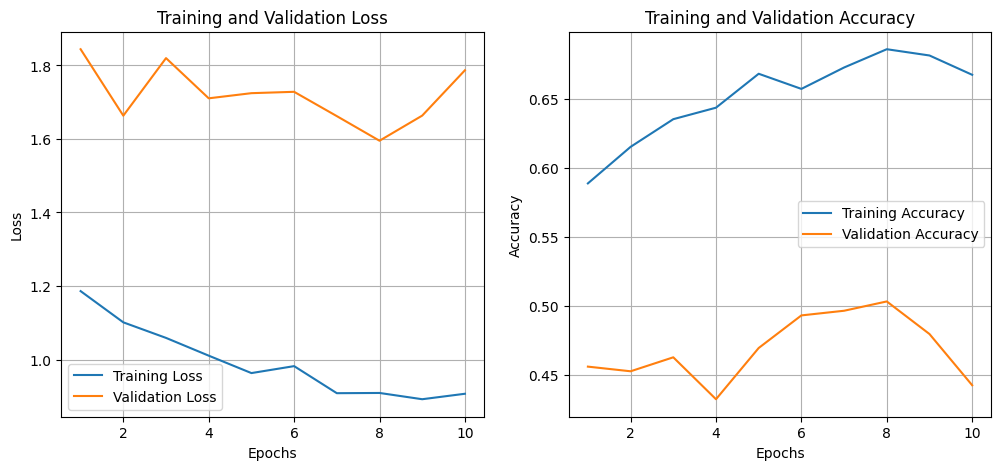

In [ ]:
new_learning_rate = learning_rate / 2
new_num_epochs = 10

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = Adam(model.parameters(), lr=new_learning_rate)

best_val_acc_4, best_params_4, best_epoch_4 = train_loop(
    model,
    train_dl,
    new_num_epochs,
    optimizer,
    val_dl,
    verbose=True
)


Increasing the training time helped us to overcome 50% accuracy on the validation set, but it's not yet enough to accomplish our goal. Let's see what happens if we **double input resolution**!

In [14]:
transform = T.Compose([
    T.ToTensor(),
    T.CenterCrop((200,200)), # <-------------
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 3.442 - train acc 0.099 - valid loss 3.338 - valid acc 0.068
Epoch 4: train loss 2.391 - train acc 0.288 - valid loss 2.482 - valid acc 0.257
Epoch 7: train loss 1.681 - train acc 0.449 - valid loss 1.998 - valid acc 0.345
Epoch 10: train loss 1.403 - train acc 0.520 - valid loss 1.683 - valid acc 0.486
Epoch 13: train loss 1.215 - train acc 0.581 - valid loss 1.679 - valid acc 0.463
Epoch 15: train loss 1.097 - train acc 0.608 - valid loss 1.580 - valid acc 0.480
Best epoch 10, best acc 0.486


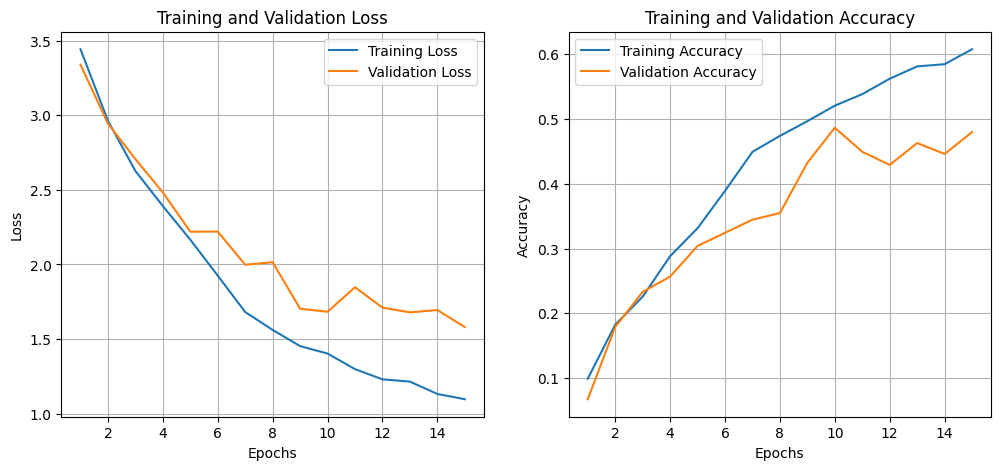

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Model3(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc_5, best_params_5, best_epoch_5 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True
)

By only increasing input resolution we were able to reach about 50% accuracy on the validation set without any increase on the training time! The trends suggests the model might continue improving with additional epochs: we are following the right path, but there are still some things we could try before increasing training time. We need to speed up the learning somehow since it became too slow.
What if we add **batch normalization**? Our batchsize of 64 allows us to do it, so let's see how does it perform!

# Batch Normalization
Let's add batch normalization to every convolutional layer.

In [10]:
class Model4(nn.Module):
  def __init__(self, n_classes: int):
    super().__init__()
    self.features = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <-------------
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <-------------
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <-------------
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 512, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None), # <-------------
    nn.AdaptiveAvgPool2d((1, 1))
    )
    self.classifier = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(512, 1024),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(1024, n_classes)
    )

  def forward(self, x):
      x = self.features(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 2.480 - train acc 0.291 - valid loss 2.607 - valid acc 0.206
Epoch 4: train loss 1.183 - train acc 0.592 - valid loss 1.736 - valid acc 0.446
Epoch 7: train loss 0.834 - train acc 0.714 - valid loss 1.555 - valid acc 0.551
Epoch 10: train loss 0.696 - train acc 0.759 - valid loss 1.683 - valid acc 0.497
Epoch 13: train loss 0.493 - train acc 0.827 - valid loss 1.630 - valid acc 0.564
Epoch 15: train loss 0.430 - train acc 0.847 - valid loss 1.842 - valid acc 0.524
Best epoch 13, best acc 0.564


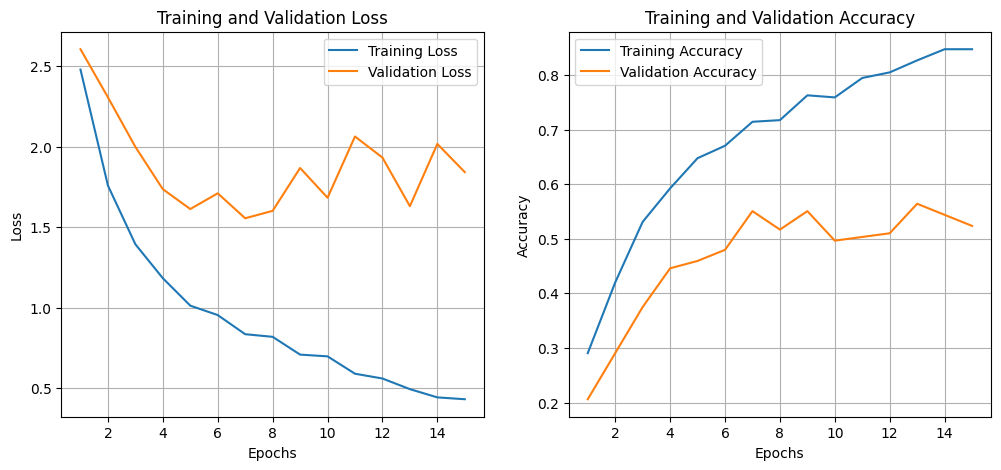

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

best_val_acc_6, best_params_6, best_epoch_6 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True
)


Batch normalization made learning surprisingly faster! We reached the same validation accuracy as before in just 6 epochs, and we almost accomplished our goal with a top accuracy of about 57%. A good **learning rate schedule** could help us in finding a better minima of our loss function and might allow the model to reach our 60% accuracy goal on the validation set. Since we saw a plateau on validation accuracy at around epoch 7, let's try with a simple **step learning rate schedule**, by **halving** it every **7 epochs**.

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 2.482 - train acc 0.291 - valid loss 2.573 - valid acc 0.223 - lr: 0.001
Epoch 2: train loss 1.717 - train acc 0.444 - valid loss 1.961 - valid acc 0.358 - lr: 0.001
Epoch 3: train loss 1.419 - train acc 0.533 - valid loss 1.843 - valid acc 0.446 - lr: 0.001
Epoch 4: train loss 1.211 - train acc 0.597 - valid loss 1.877 - valid acc 0.436 - lr: 0.001
Epoch 5: train loss 1.022 - train acc 0.658 - valid loss 1.475 - valid acc 0.554 - lr: 0.001
Epoch 6: train loss 0.925 - train acc 0.684 - valid loss 1.650 - valid acc 0.524 - lr: 0.001
Epoch 7: train loss 0.858 - train acc 0.708 - valid loss 1.497 - valid acc 0.520 - lr: 0.001
Epoch 8: train loss 0.655 - train acc 0.780 - valid loss 1.471 - valid acc 0.581 - lr: 0.0005
Epoch 9: train loss 0.621 - train acc 0.790 - valid loss 1.531 - valid acc 0.544 - lr: 0.0005
Epoch 10: train loss 0.542 - train acc 0.818 - valid loss 1.376 - valid acc 0.622 - lr: 0.0005
Epoch 11: train loss 0.541 - train acc 0.813 - valid loss 1.624 - 

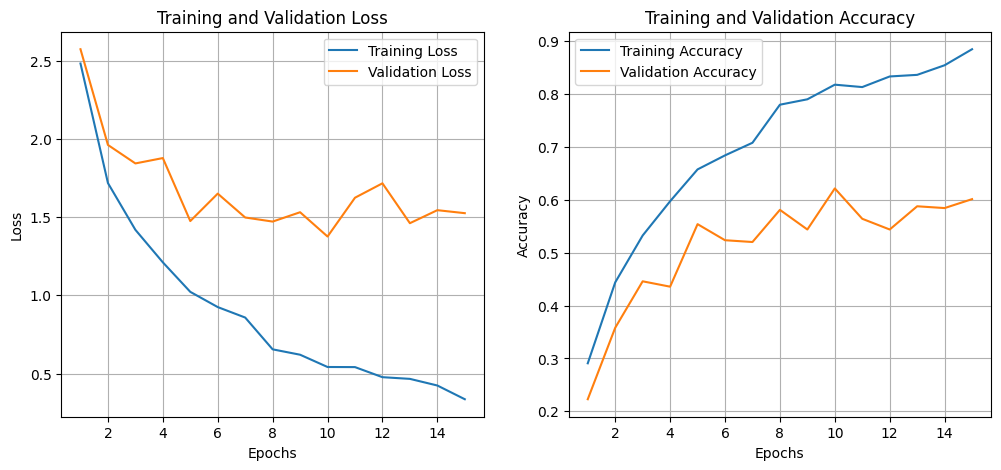

In [17]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc_7, best_params_7, best_epoch_7 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler
)


We've finally reached our goal! By lowering the learning rate we've been able to improve the accuracy, obtaining more than 62% on the validation set!  Let's save the model parameters.

In [24]:
torch.save(best_params_7, "my_best_model.pth")

Just for the sake of curiosity, what if we try to **augment the dataset**? Theoretically, we should increase the accuracy, but let's see!
We will apply **random rotation** and **horizontal flip** on our centered 200x200 image. Clearly, the transformation is applied only to the training dataset!

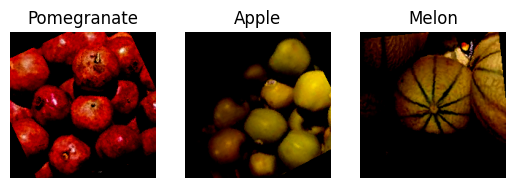

In [ ]:
transform_train = T.Compose([
    T.ToTensor(),
    T.CenterCrop((200,200)),
    T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    T.RandomRotation(30),      # Randomly rotate the image by 30 degrees
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
transform_test = T.Compose([
    T.ToTensor(),
    T.CenterCrop((200,200)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = GroceryStoreDataset(split='train', transform=transform_train)
val_dataset = GroceryStoreDataset(split='val', transform=transform_test)
test_dataset = GroceryStoreDataset(split='test', transform=transform_test)

batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

_, ax = plt.subplots(1, 3)

for i, idx in enumerate([1024, 6, 524]):
    img, label = train_dataset[idx]
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].set_title(label_to_name.get(label))
    ax[i].axis("off")

Let's train again the model using the data augmentation!

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 2.476 - train acc 0.290 - valid loss 2.848 - valid acc 0.189 - lr: 0.001
Epoch 2: train loss 1.753 - train acc 0.425 - valid loss 2.242 - valid acc 0.385 - lr: 0.001
Epoch 3: train loss 1.445 - train acc 0.522 - valid loss 2.054 - valid acc 0.392 - lr: 0.001
Epoch 4: train loss 1.166 - train acc 0.598 - valid loss 2.136 - valid acc 0.399 - lr: 0.001
Epoch 5: train loss 1.187 - train acc 0.594 - valid loss 1.910 - valid acc 0.439 - lr: 0.001
Epoch 6: train loss 1.046 - train acc 0.644 - valid loss 1.795 - valid acc 0.497 - lr: 0.001
Epoch 7: train loss 0.920 - train acc 0.679 - valid loss 1.657 - valid acc 0.527 - lr: 0.001
Epoch 8: train loss 0.746 - train acc 0.748 - valid loss 1.527 - valid acc 0.568 - lr: 0.0005
Epoch 9: train loss 0.712 - train acc 0.750 - valid loss 1.612 - valid acc 0.554 - lr: 0.0005
Epoch 10: train loss 0.650 - train acc 0.773 - valid loss 1.645 - valid acc 0.568 - lr: 0.0005
Epoch 11: train loss 0.608 - train acc 0.780 - valid loss 1.570 - 

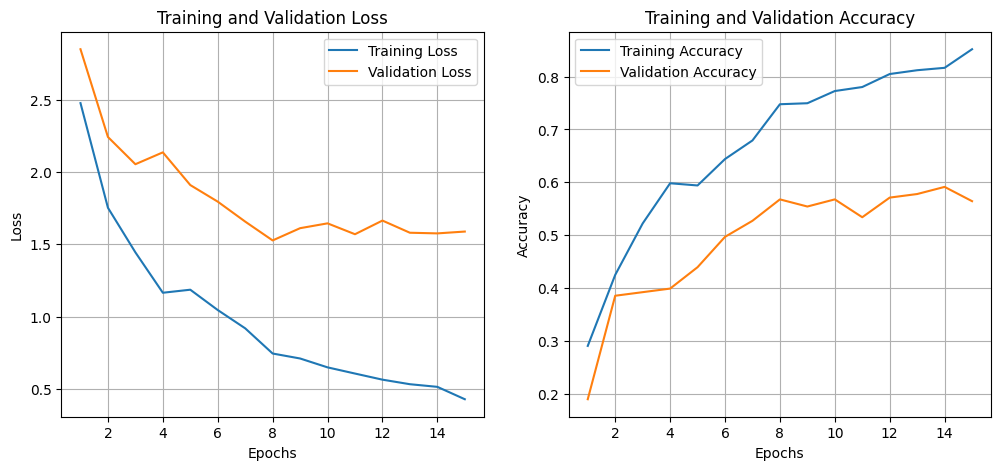

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = Model4(n_classes=n_classes).to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc_8, best_params_8, best_epoch_8 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler
)

If we compare the plots with the ones before applying data augmentation, we cannot appreciate any improvement on the learning and the results are actually worse! It's very likely that this simple architecture is not able to extract valuable features from the augmented dataset.  
It was worth to try tho! Let's stick with our previous results and we can consider ourselves satisfied.

## Testing our best model
Let's test our model on the test set and see the accuracy.

In [27]:
test_model(model, best_params_7, test_dl, 'Test')

Test Accuracy: 64.95%


## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

## 1. Let's instantiate a ResNet-18 model with default weights and let's fine-tune it with the best hyperparameters used for our best model.  
We set:
- resolution 200x200 pixel cropped at the center
- batch size = 64
- learning rate = 0.001
- epochs of training = 15
- learning rate schedule halving every 7 epochs

In [40]:
transform = T.Compose([
    T.ToTensor(),
    T.CenterCrop((200,200)),
    T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
])

train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

n_classes = train_dataset.get_num_classes()

# Hyperparameters
learning_rate = 0.001
num_epochs = 15

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 1.041 - train acc 0.718 - valid loss 2.083 - valid acc 0.483 - lr: 0.001
Epoch 2: train loss 0.304 - train acc 0.913 - valid loss 1.456 - valid acc 0.649 - lr: 0.001
Epoch 3: train loss 0.283 - train acc 0.915 - valid loss 1.467 - valid acc 0.625 - lr: 0.001
Epoch 4: train loss 0.162 - train acc 0.955 - valid loss 0.961 - valid acc 0.750 - lr: 0.001
Epoch 5: train loss 0.113 - train acc 0.972 - valid loss 1.114 - valid acc 0.730 - lr: 0.001
Epoch 6: train loss 0.086 - train acc 0.977 - valid loss 1.191 - valid acc 0.679 - lr: 0.001
Epoch 7: train loss 0.041 - train acc 0.990 - valid loss 1.073 - valid acc 0.720 - lr: 0.001
Epoch 8: train loss 0.024 - train acc 0.996 - valid loss 0.858 - valid acc 0.736 - lr: 0.0005
Epoch 9: train loss 0.006 - train acc 0.999 - valid loss 0.834 - valid acc 0.774 - lr: 0.0005
Epoch 10: train loss 0.004 - train acc 1.000 - valid loss 0.802 - valid acc 0.784 - lr: 0.0005
Epoch 11: train loss 0.002 - train acc 1.000 - valid loss 0.778 - 

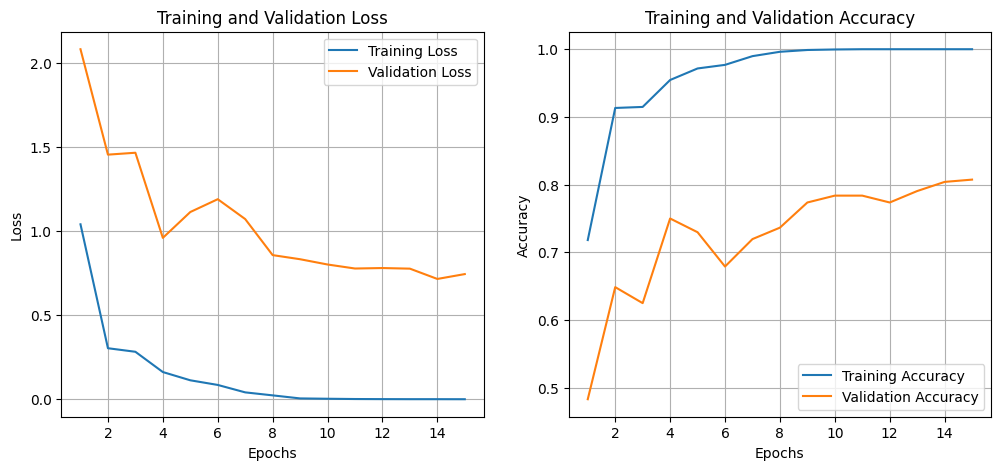

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task

model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc_9, best_params_9, best_epoch_9 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    scheduler = scheduler
)


Our starting hyperparameters are already satisfying: almost 81% accuracy on validation set. Let's try to tune them a bit to squeeze some performance.

## 2. Tuning the hyperparameters
Let's try by introducing some new regularization to our model to increase it's capacity. We can try by adding a **label_smoothing** of 0.1 to the Cross Entropy Loss and see how it performs.

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 1.622 - train acc 0.713 - valid loss 1.967 - valid acc 0.578 - lr: 0.001
Epoch 2: train loss 1.014 - train acc 0.925 - valid loss 1.855 - valid acc 0.598 - lr: 0.001
Epoch 3: train loss 0.874 - train acc 0.969 - valid loss 1.677 - valid acc 0.682 - lr: 0.001
Epoch 4: train loss 0.821 - train acc 0.986 - valid loss 1.510 - valid acc 0.736 - lr: 0.001
Epoch 5: train loss 0.773 - train acc 0.994 - valid loss 1.404 - valid acc 0.760 - lr: 0.001
Epoch 6: train loss 0.781 - train acc 0.987 - valid loss 1.387 - valid acc 0.747 - lr: 0.001
Epoch 7: train loss 0.749 - train acc 0.997 - valid loss 1.381 - valid acc 0.791 - lr: 0.001
Epoch 8: train loss 0.727 - train acc 1.000 - valid loss 1.305 - valid acc 0.818 - lr: 0.0005
Epoch 9: train loss 0.712 - train acc 1.000 - valid loss 1.250 - valid acc 0.841 - lr: 0.0005
Epoch 10: train loss 0.706 - train acc 1.000 - valid loss 1.297 - valid acc 0.824 - lr: 0.0005
Epoch 11: train loss 0.704 - train acc 1.000 - valid loss 1.266 - 

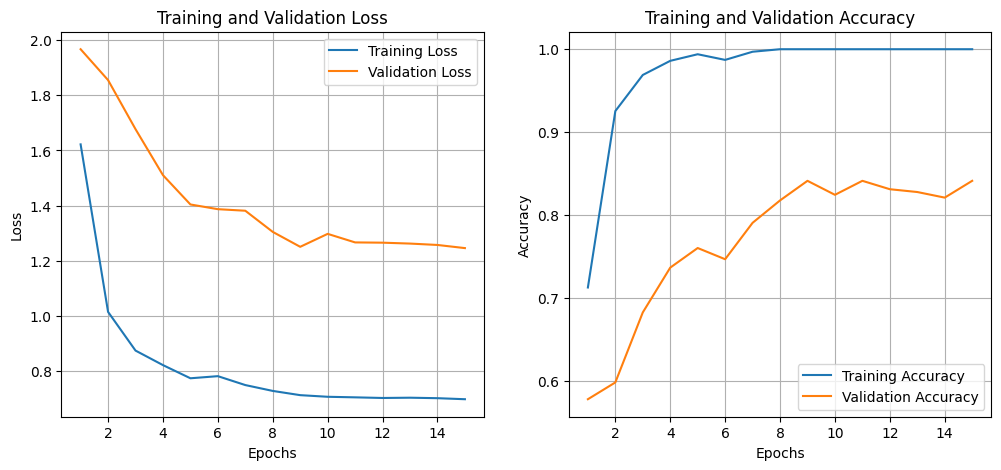

In [41]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc_10, best_params_10, best_epoch_10 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1, # <--------------------------
    scheduler = scheduler,

)


The trends are similar to the previous ones but we have achieved a better accuracy! Label smoothing turned out to be beneficial.

In part 1 we have tried to augment the dataset without any appreciable improvements. Nevertheless, ResNet18 is a much deeper and more complex architecture which might be able to maximize the use of an augmented dataset.  
At https://medium.com/@zeyneptufekci.etu/resnet-with-data-augmentation-71d3031cd4b3#:~:text=improved%20accuracy%20result is explained how data augmentation on ResNet has improved the accuracy.  
Let's try it out by introducing random variation of the viewpoints of the image: **random rotations** and **flipping** horizontally.

In [42]:
transform_train = T.Compose([
    T.ToTensor(),
    T.CenterCrop((200,200)),
    T.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally # <--------------------------
    T.RandomRotation(30),      # Randomly rotate the image by 30 degrees # <--------------------------
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
transform_test = T.Compose([
    T.ToTensor(),
    T.CenterCrop((200,200)),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = GroceryStoreDataset(split='train', transform=transform_train)
val_dataset = GroceryStoreDataset(split='val', transform=transform_test)
test_dataset = GroceryStoreDataset(split='test', transform=transform_test)

batch_size = 64

train_dl = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dl = DataLoader(
    val_dataset,
    batch_size=batch_size
)
test_dl = DataLoader(
    test_dataset,
    batch_size=batch_size
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1: train loss 1.699 - train acc 0.684 - valid loss 4.051 - valid acc 0.301 - lr: 0.001
Epoch 2: train loss 1.150 - train acc 0.863 - valid loss 1.695 - valid acc 0.682 - lr: 0.001
Epoch 3: train loss 0.979 - train acc 0.931 - valid loss 1.545 - valid acc 0.720 - lr: 0.001
Epoch 4: train loss 0.923 - train acc 0.947 - valid loss 1.744 - valid acc 0.689 - lr: 0.001
Epoch 5: train loss 0.873 - train acc 0.964 - valid loss 1.559 - valid acc 0.713 - lr: 0.001
Epoch 6: train loss 0.858 - train acc 0.966 - valid loss 1.428 - valid acc 0.760 - lr: 0.001
Epoch 7: train loss 0.813 - train acc 0.981 - valid loss 1.405 - valid acc 0.770 - lr: 0.001
Epoch 8: train loss 0.754 - train acc 0.996 - valid loss 1.208 - valid acc 0.845 - lr: 0.0005
Epoch 9: train loss 0.734 - train acc 0.999 - valid loss 1.181 - valid acc 0.855 - lr: 0.0005
Epoch 10: train loss 0.724 - train acc 0.999 - valid loss 1.201 - valid acc 0.831 - lr: 0.0005
Epoch 11: train loss 0.725 - train acc 0.997 - valid loss 1.225 - 

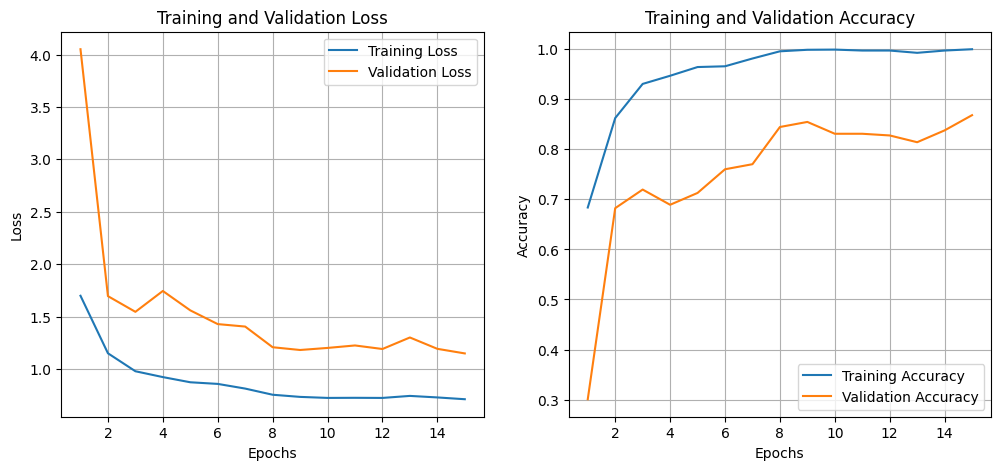

In [43]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc_11, best_params_11, best_epoch_11 = train_loop(
    model,
    train_dl,
    num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1,
    scheduler = scheduler,

)


With data augmentation we've been able to reach around 87% of accuracy, setting it to the best one so far!  
The validation loss is also lower, so we are happy to keep applied this transformation to our dataset.  
Even tho we might try to investigate more sofisticated augmentation technique, the trend suggests that we could try to increase the training time and see if the model keeps learning.

Let's try to train for a total of **20 epochs** to see if our model improves!

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: train loss 1.677 - train acc 0.695 - valid loss 2.727 - valid acc 0.443 - lr: 0.001
Epoch 2: train loss 1.154 - train acc 0.856 - valid loss 1.935 - valid acc 0.601 - lr: 0.001
Epoch 3: train loss 0.997 - train acc 0.925 - valid loss 1.705 - valid acc 0.655 - lr: 0.001
Epoch 4: train loss 0.902 - train acc 0.954 - valid loss 1.532 - valid acc 0.699 - lr: 0.001
Epoch 5: train loss 0.887 - train acc 0.956 - valid loss 1.372 - valid acc 0.767 - lr: 0.001
Epoch 6: train loss 0.849 - train acc 0.968 - valid loss 1.421 - valid acc 0.736 - lr: 0.001
Epoch 7: train loss 0.812 - train acc 0.983 - valid loss 1.397 - valid acc 0.797 - lr: 0.001
Epoch 8: train loss 0.763 - train acc 0.995 - valid loss 1.221 - valid acc 0.828 - lr: 0.0005
Epoch 9: train loss 0.741 - train acc 0.995 - valid loss 1.217 - valid acc 0.828 - lr: 0.0005
Epoch 10: train loss 0.725 - train acc 1.000 - valid loss 1.283 - valid acc 0.821 - lr: 0.0005
Epoch 11: train loss 0.719 - train acc 1.000 - valid loss 1.278 - 

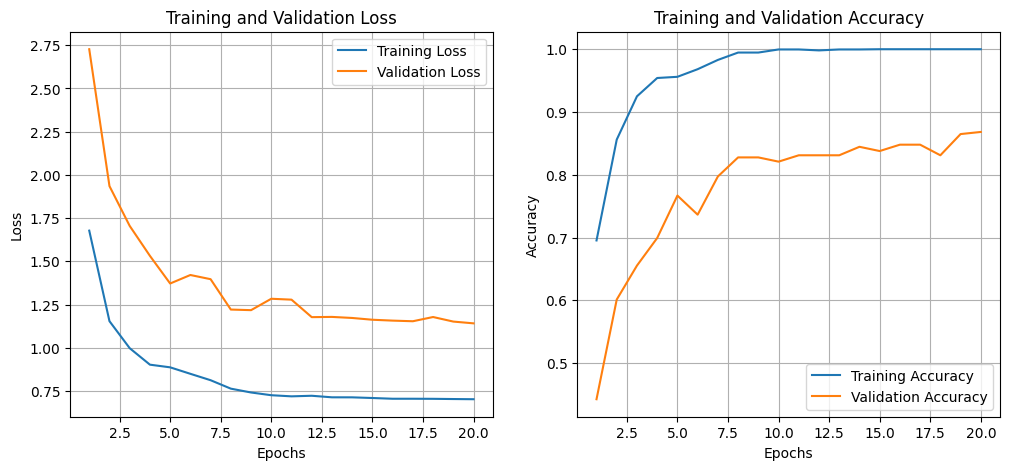

In [61]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
model = model.to(device)

new_num_epochs = 20 # <--------------------------

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)

best_val_acc_12, best_params_12, best_epoch_12 = train_loop(
    model,
    train_dl,
    new_num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1,
    scheduler = scheduler,

)


We're stuck with the same accuracy! Stocasticity plays it's role, but increasing training time seems to be not really effective.  
Before we stop, in all these experiments we have noticed that a **good learning** schedule is **the key** to increase our model performances: in all our last trainings we have seen a slight increase in accuracy after the first halving of the learning rate, which is currently every 7 epochs.  
Let's bring it to every **5 epochs**, so that it changes 4 times in a total of 20 epochs! It may be worth to try.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: train loss 1.778 - train acc 0.666 - valid loss 2.119 - valid acc 0.561 - lr: 0.001
Epoch 2: train loss 1.136 - train acc 0.877 - valid loss 1.826 - valid acc 0.632 - lr: 0.001
Epoch 3: train loss 0.959 - train acc 0.937 - valid loss 1.556 - valid acc 0.709 - lr: 0.001
Epoch 4: train loss 0.914 - train acc 0.954 - valid loss 1.431 - valid acc 0.767 - lr: 0.001
Epoch 5: train loss 0.870 - train acc 0.965 - valid loss 1.557 - valid acc 0.713 - lr: 0.001
Epoch 6: train loss 0.799 - train acc 0.986 - valid loss 1.368 - valid acc 0.760 - lr: 0.0005
Epoch 7: train loss 0.751 - train acc 0.996 - valid loss 1.198 - valid acc 0.824 - lr: 0.0005
Epoch 8: train loss 0.744 - train acc 0.997 - valid loss 1.279 - valid acc 0.804 - lr: 0.0005
Epoch 9: train loss 0.738 - train acc 0.995 - valid loss 1.235 - valid acc 0.828 - lr: 0.0005
Epoch 10: train loss 0.749 - train acc 0.994 - valid loss 1.174 - valid acc 0.838 - lr: 0.0005
Epoch 11: train loss 0.724 - train acc 1.000 - valid loss 1.154 

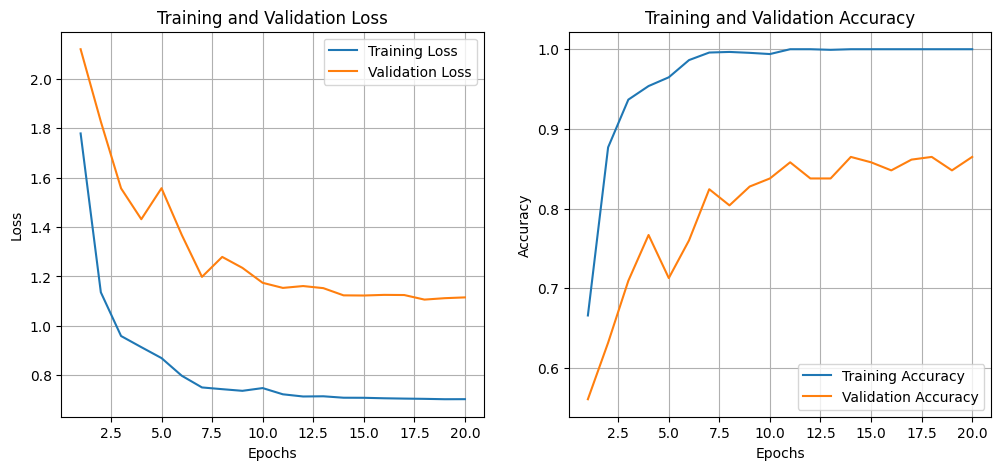

In [63]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model, loss function, and optimizer
model = models.resnet18(weights='DEFAULT')
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, n_classes) # Necessary to adjust the output classes for our task
model = model.to(device)

new_num_epochs = 20

optimizer = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # <--------------------------

best_val_acc_13, best_params_13, best_epoch_13 = train_loop(
    model,
    train_dl,
    new_num_epochs,
    optimizer,
    val_dl,
    verbose=True,
    label_smoothing=0.1,
    scheduler = scheduler,

)


Close results, no improvements. Our best configuration is the former!  
It is worth to highlight that we could have experimented more sofisticated data augmentation techniques and more effective scheduling learning rate (which turned out to be crucial), but we consider ourselves satisfied with the achievements reached so far.  
Let's save the parameters!

In [70]:
torch.save(best_params_12, "resnet_best_model.pth")

## Testing our best model
Let's test our model on the test set and see the accuracy.

In [69]:
test_model(model, best_params_12, test_dl)

Test Accuracy: 90.22%
